In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
import warnings
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

In [3]:
 matches_df = pd.read_parquet("./esta/parsed/matches.parquet")
 rounds_df = pd.read_parquet("./esta/parsed/rounds.parquet")
 kills_df = pd.read_parquet("./esta/parsed/kills.parquet")
 damages_df = pd.read_parquet("./esta/parsed/damages.parquet") 
 grenades_df = pd.read_parquet("./esta/parsed/grenades.parquet") 
 bomb_events_df = pd.read_parquet("./esta/parsed/bomb_events.parquet") 
 weapon_fires_df = pd.read_parquet("./esta/parsed/weapon_fires.parquet") 
 flashes_df = pd.read_parquet("./esta/parsed/flashes.parquet") 
 frames_df = pd.read_parquet("./esta/parsed/frames.parquet")
 players_df = pd.read_parquet("./esta/parsed/players.parquet") 
 team_frames_df = pd.read_parquet("./esta/parsed/team_frames.parquet") 
 player_frames_df = pd.read_parquet("./esta/parsed/player_frames.parquet") 
 inventory_df = pd.read_parquet("./esta/parsed/inventory.parquet") 
 bomb_location_df = pd.read_parquet("./esta/parsed/bomb_location.parquet") 
 projectiles_df = pd.read_parquet("./esta/parsed/projectiles.parquet") 
 smokes_df = pd.read_parquet("./esta/parsed/smokes.parquet") 
 fires_df = pd.read_parquet("./esta/parsed/fires.parquet") 

image_dim = 1024

In [4]:
with open(".awpy/maps/map-data.json", "r") as f:
    map_data_all = json.load(f)

print(type(map_data_all))

<class 'dict'>


# analysis over single round

In [5]:
selected_map = 'de_mirage'

In [6]:
selected_matches = matches_df[matches_df.map_name == selected_map]
selected_matches.head()

,client_name,map_name,tick_rate,playback_ticks,playback_frames_count,parsed_to_frame_idx,match_id,demo_id,competition_name,hltv_url,match_date,match_name
0,GOTV Demo,de_mirage,127,343251,342767,342784,0839a031-0e2c-4c03-b4bc-b5ba05fe669a,01746483-b3bd-4e4b-a2f2-0de97b17600d,PGL Major Antwerp 2022,https://www.hltv.org/matches/2356160/heroic-vs...,1652781600000,heroic-vs-vitality-pgl-major-antwerp-2022
0,GOTV Demo,de_mirage,127,471790,471564,471581,0a075b4d-576e-46f2-b944-fe9542faee54,04f0fb8f-a4d7-497c-857e-316300fadee3,IEM Katowice 2022,https://www.hltv.org/matches/2354381/furia-vs-...,1645124400000,furia-vs-astralis-iem-katowice-2022
0,GOTV Demo,de_mirage,127,426251,425998,426016,a98ffca7-e968-4a54-9e8f-22f101c2502b,022866a3-090e-42eb-ab8e-aa553a575ada,IEM Katowice 2021,https://www.hltv.org/matches/2346573/faze-vs-f...,1613905200000,faze-vs-furia-iem-katowice-2021
0,GOTV Demo,de_mirage,127,441259,440692,440707,a56115fd-a0ba-4eea-a618-91fd6c57177c,015f7c8d-2bc0-4d83-88e7-60648d2b221c,BLAST Premier Fall Showdown 2021,https://www.hltv.org/matches/2351973/heroic-vs...,1634034600000,heroic-vs-poggerz-blast-premier-fall-showdown-...
0,GOTV Demo,de_mirage,127,493224,492014,492029,f218743d-5e8b-436e-91bd-b7b3664c56c3,0418eb19-853e-4b56-955c-d3eedf2b7e12,BLAST Premier Spring Final 2021,https://www.hltv.org/matches/2349173/natus-vin...,1623853200000,natus-vincere-vs-faze-blast-premier-spring-fin...


## location based analysis over single round

In [16]:
idx_pf_df = player_frames_df.set_index(["match_id","round_num"])
idx_f_df = flashes_df.set_index(["match_id","round_num"])
idx_sm_df = smokes_df.set_index(["match_id","round_num"])

### transform functions
so data fit the plotting format

In [8]:
def transform_coord(map_data,player_loc):
    result = player_loc.copy()
        
    pos_x = map_data["pos_x"]
    pos_y = map_data["pos_y"]
    scale = map_data["scale"]

    result["x"] = (result["x"] - pos_x) / scale
    result["y"] = image_dim - (pos_y - result["y"]) / scale

    return result

In [9]:
def transform_flash(flashes):
    no_idx_flashes = flashes.reset_index(drop=True)
    flashers = no_idx_flashes[["attacker_x","attacker_y","tick","attacker_side"]]
    flasheds = no_idx_flashes[["player_x","player_y","tick","player_side"]]

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
        flashers.loc[:,"type"] = "flasher"
        flasheds.loc[:,"type"] = "flashed"
        
    flashers.columns = ["x","y","tick","side","type"]
    flasheds.columns = ["x","y","tick","side","type"]

    result = pd.concat([flashers,flasheds]).reset_index(drop=True).sort_values(by=["tick"])
    result["tick"] = result["tick"] - result["tick"].min()

    return result

### plotting functions

In [10]:
def plot_map(map_name,fig_size,fig=None,ax=None):
    fig,ax = plt.subplots(figsize=fig_size)
    map_img = plt.imread(f".awpy/maps/{map_name}.png")
    ax.imshow(map_img,extent=[0,image_dim,0,image_dim])
    ax.set_xlim(0, image_dim)
    ax.set_ylim(0, image_dim)
    ax.set_title(map_name.title())
    return fig,ax

In [11]:
def count_colorbar(fig):
    result = 0
    for ax in fig.axes:
        if "colorbar" in ax.get_label():
            result += 1
    return result

In [31]:
def plot_loc_unicode(player_loc, 
                     gradient_by, 
                     size,
                     color_by=None,
                     color_dict=None,
                     marker_by=None,
                     marker_dict=None,
                     fig=None, ax=None):
    if fig is None and ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    selected_col = ["x","y",gradient_by]
    if color_by is not None:
        selected_col.append(color_by)

    if marker_by is not None:
        selected_col.append(marker_by)

    transformed = player_loc.reset_index()[selected_col]
    transformed[color_by] = transformed[color_by].str.lower()

    # Define Unicode marker symbols and colormaps.
    
    side = ['left', 'right']

    n_colorbar = count_colorbar(fig)
    for idx,row in transformed.iterrows():
        color = plt.get_cmap(color_dict[row[color_by]])(row[gradient_by])
        if marker_by is None:
            ax.scatter(row["x"],row["y"],color=color,s=size,alpha=0.5)
        else:
            ax.text(row["x"], row["y"], marker_dict[row[marker_by]], 
                    fontsize=size, color=color, ha='center', va='center',
                   alpha=0.5)


    ax.set_xlabel("X Coordinate (pixels)")
    ax.set_ylabel("Y Coordinate (pixels)")
    for idx,(color_cat,cmap) in enumerate(list(color_dict.items())[:2-n_colorbar]):
        positions = transformed[transformed[color_by] == color_cat]
        dummy_scatter = ax.scatter(positions['x'], positions['y'], c=positions[gradient_by], cmap=cmap,s=0, alpha=.5)
        cbar = fig.colorbar(dummy_scatter, ax=ax, location=side[idx], pad=0.02,
                                    fraction=0.046, shrink=0.6)
        cbar.set_label(f"{color_cat.upper()} {gradient_by.title()}", fontsize=8)
        cbar.ax.tick_params(labelsize=7)
    return fig, ax


In [46]:
def plot_loc_unicode(player_loc, 
                     gradient_by, 
                     size,
                     color_by=None,
                     color_dict=None,
                     default_color="viridis",  # Default colormap when color_by is None
                     alpha=0.5,
                     marker_by=None,
                     marker_dict=None,
                     default_marker="o",       # Default marker when marker_by is None
                     fig=None, ax=None):
    if fig is None and ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    selected_col = ["x","y",gradient_by]
    if color_by is not None:
        selected_col.append(color_by)
    if marker_by is not None:
        selected_col.append(marker_by)
    transformed = player_loc.reset_index()[selected_col]
    
    # Create normalization using min and max from the dataframe
    vmin = transformed[gradient_by].min()
    vmax = transformed[gradient_by].max()
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    
    # Process color_by if it exists
    if color_by is not None:
        transformed[color_by] = transformed[color_by].str.lower()
    
    # Define side positions for colorbar
    side = ['left', 'right']
    
    n_colorbar = count_colorbar(fig)
    
    for idx, row in transformed.iterrows():
        if color_by is not None:
            cmap = plt.get_cmap(color_dict[row[color_by]])
        else:
            cmap = plt.get_cmap(default_color)
        
        # Apply normalization
        color_value = norm(row[gradient_by])
        color = cmap(color_value)

        if marker_by is None:
            marker_char = default_marker  # Use default marker
        else:
            marker_char = marker_dict[row[marker_by]]
            
        # Use ax.text for all cases
        ax.text(row["x"], row["y"], marker_char, 
                fontsize=size, color=color, ha='center', va='center',
                alpha=alpha)
        
    ax.set_xlabel("X Coordinate (pixels)")
    ax.set_ylabel("Y Coordinate (pixels)")
    
    # Only create colorbars when color_by is specified
    if color_by is not None:
        for idx, (color_cat, cmap) in enumerate(list(color_dict.items())[:2-n_colorbar]):
            positions = transformed[transformed[color_by] == color_cat]
            dummy_scatter = ax.scatter(positions['x'], positions['y'], 
                                      c=positions[gradient_by], 
                                      cmap=cmap, s=0, alpha=.5,
                                      norm=norm)  # Apply the normalization
            cbar = fig.colorbar(dummy_scatter, ax=ax, location=side[idx], pad=0.02,
                               fraction=0.046, shrink=0.6)
            cbar.set_label(f"{color_cat.upper()} {gradient_by.title()}", fontsize=8)
            cbar.ax.tick_params(labelsize=7)
    
    return fig, ax

### test plotting functions with players' location and flashes' location

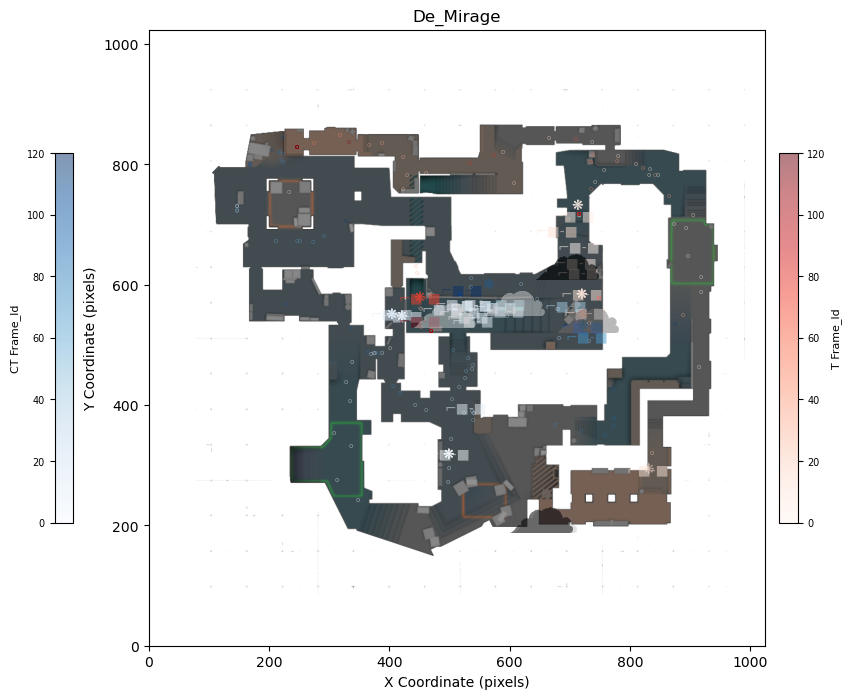

In [56]:
selected_match = selected_matches.iloc[0]
selected_round = 10

transformed_flash = transform_flash(idx_f_df.loc[(selected_match.match_id,selected_round)])
transformed_flash = transform_coord(map_data_all[selected_map],transformed_flash)
# transformed_flash = transformed_flash[transformed_flash["type"] == "flasher"]

transformed_loc = transform_coord(map_data_all[selected_map],
                                  idx_pf_df.loc[(selected_match.match_id,selected_round)].iloc[
                                  ::5
                                  ])

transformed_smoke = transform_coord(map_data_all[selected_map],
                                   idx_sm_df.loc[(selected_match.match_id,selected_round)])
side_color = {
    "ct" : "Blues",
    "t" : "Reds"
}

flash_marker = {
    "flasher" : "$\u274B$",
    "flashed" : "⌐■-■",
}
img_fig, img_ax = plot_map(selected_map, (10, 8))

loc_fig, loc_ax = plot_loc_unicode(transformed_loc, 
                                  gradient_by="frame_id", 
                                  size=5,
                                  color_by="side",
                                  color_dict=side_color,
                                  fig=img_fig, 
                                  ax=img_ax)

flash_fig, flash_ax = plot_loc_unicode(transformed_flash, 
                                      gradient_by="tick", 
                                      size=10,
                                      color_by="side",
                                      color_dict=side_color,
                                      marker_by="type",
                                      marker_dict=flash_marker,
                                      fig=loc_fig, 
                                      ax=loc_ax)

smoke_fig, smoke_ax = plot_loc_unicode(transformed_smoke, 
                                      gradient_by="start_tick", 
                                      size=50,
                                      default_color="Grays",
                                      default_marker='$\u2601$',
                                      alpha=0.02,
                                      fig=flash_fig, 
                                      ax=flash_ax)

plt.show()

In [28]:
kills_df.columns

Index(['tick', 'seconds', 'clock_time', 'attacker_steam_id', 'attacker_name',
       'attacker_team', 'attacker_side', 'attacker_x', 'attacker_y',
       'attacker_z', 'attacker_view_x', 'attacker_view_y', 'victim_steam_id',
       'victim_name', 'victim_team', 'victim_side', 'victim_x', 'victim_y',
       'victim_z', 'victim_view_x', 'victim_view_y', 'is_suicide',
       'is_teamkill', 'is_wallbang', 'penetrated_objects', 'is_first_kill',
       'is_headshot', 'victim_blinded', 'attacker_blinded', 'no_scope',
       'thru_smoke', 'distance', 'is_trade', 'weapon', 'weapon_class',
       'round_num', 'match_id', 'player_traded_name', 'player_traded_team',
       'player_traded_steam_id', 'assister_steam_id', 'assister_name',
       'assister_team', 'assister_side', 'flash_thrower_steam_id',
       'flash_thrower_name', 'flash_thrower_team', 'flash_thrower_side'],
      dtype='object')

In [ ]:
grenades_df.columns

In [ ]:
projectiles_df.columns

In [ ]:
rounds_df.columns

In [18]:
idx_sm_df.loc[(selected_match.match_id,selected_round)]

grenade_entity_id  \
match_id                             round_num                        
0839a031-0e2c-4c03-b4bc-b5ba05fe669a 10         3413697630947925421   
                                     10         5819697006064706810   
                                     10         3413697630947925421   
                                     10         5819697006064706810   
                                     10         3413697630947925421   
...                                                             ...   
                                     10         8074640487395059988   
                                     10         6719190960263234142   
                                     10         8074640487395059988   
                                     10         6719190960263234142   
                                     10         8074640487395059988   

                                                start_tick           x  \
match_id                             round_num                           
0839a031-0e2c-4c03-b4bc-b5ba05fe669a 10             145519 -206.876358   
                                     10             145574 -781.097107   
                                     10             145519 -206.876358   
                                     10             145574 -781.097107   
                                     10             145519 -206.876358   
...                                                    ...         ...   
                                     10             147471  242.557022   
                                     10             147392   24.765303   
                                     10             147471  242.557022   
                                     10             147392   24.765303   
                                     10             147471  242.557022   

                                                          y           z  \
match_id                             round_num                            
0839a031-0e2c-4c03-b4bc-b5ba05fe669a 10         -496.480988 -165.977982   
                                     10         -595.424500 -270.731720   
                                     10         -496.480988 -165.977982   
                                     10         -595.424500 -270.731720   
                                     10         -496.480988 -165.977982   
...                                                     ...         ...   
                                     10         -198.933670 -164.413986   
                                     10        -2302.866943  -37.968750   
                                     10         -198.933670 -164.413986   
                                     10        -2302.866943  -37.968750   
                                     10         -198.933670 -164.413986   

                                                frame_id  
match_id                             round_num            
0839a031-0e2c-4c03-b4bc-b5ba05fe669a 10               14  
                                     10               14  
                                     10               15  
                                     10               15  
                                     10               16  
...                                                  ...  
                                     10               77  
                                     10               77  
                                     10               78  
                                     10               78  
                                     10               79  

[181 rows x 6 columns]